In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
%matplotlib inline

In [2]:
# load data from csv
df = pd.read_csv('sentiment-data-clean.csv', index_col='index')

# store length of original df for use later
orig_len = len(df)
# display first 5 rows of df
df.head().round(3)
orig_len

1463

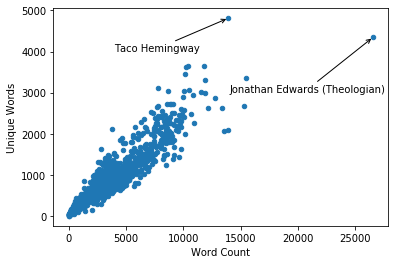

In [3]:
df.plot(kind='scatter', x='Word Count', y='Unique Words')
plt.annotate('Jonathan Edwards (Theologian)', xy=(26517, 4344), xytext=(14000, 3000),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('Taco Hemingway', xy=(13903, 4810), xytext=(4000, 4000),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.savefig('pics/word-count.png')

In [54]:
df.sort_values('Word Count', ascending=False).head(1)

,Artist,Lyrics,Word Count,Unique Words,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
index,,,,,,,,,,,,,,
973,Jonathan Edwards (Theologian),deuteronomy xxxii 35 foot shall slide due time...,26517,4344,0.156541,0.052645,0.023758,0.099144,0.021609,0.0712,0.087717,0.028397,0.030886,0.123921


This is fascianting. Jonathan Edwards, a theologian, snuck onto this list. This is probably because there is a singer-songwriter by the same name who had a hit in 1971. I wonder why genius.com keeps lyrics information for the theologian. Perhaps there are audiobooks of his writings. 

The theologian, who is best known for his sermon "Sinners in the Hands of an Angry God,"  has a wordcount is far higher than any of the musical artists on the list. We will remove him from the dataframe, but I find the emotional content of his work faascinating. He scores high on positivity, anticipation, and joy, but also fear. Other negative emotions have low scores. 

This seems like it roughly matches the emotional content of his work, so this analysis method seems to be doing it's job. 

In [3]:
# we remove Jonathan Edwards the theologian
df = df[df.Artist !=  'Jonathan Edwards (Theologian)']

# we also remove artists with fewer than 500 unique words
# (small sample size artists may have randomly high emotion values)
df = df[df['Unique Words'] > 500]

# how many entries have we removed in this way? 
removed_rows = orig_len - len(df)
removed_rows

226

In [7]:
df.corr().style.background_gradient(cmap='coolwarm', axis=None, low=.25).set_precision(2)

,Word Count,Unique Words,Lyrical Diversity,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
Word Count,1.00,0.88,-0.29,-0.46,0.32,0.51,-0.50,0.46,0.27,-0.48,0.05,-0.16,-0.28
Unique Words,0.88,1.00,0.14,-0.40,0.33,0.49,-0.40,0.46,0.25,-0.49,0.04,-0.10,-0.17
Lyrical Diversity,-0.29,0.14,1.00,0.08,0.02,-0.04,0.19,-0.01,-0.03,-0.06,-0.01,0.09,0.24
positive,-0.46,-0.40,0.08,1.00,-0.24,-0.31,0.63,-0.25,-0.19,0.92,-0.05,0.34,0.69
negative,0.32,0.33,0.02,-0.24,1.00,0.82,-0.13,0.82,0.86,-0.32,0.76,0.25,0.02
anger,0.51,0.49,-0.04,-0.31,0.82,1.00,-0.26,0.86,0.75,-0.39,0.56,0.18,-0.06
anticipation,-0.50,-0.40,0.19,0.63,-0.13,-0.26,1.00,-0.25,-0.10,0.63,0.03,0.51,0.66
disgust,0.46,0.46,-0.01,-0.25,0.82,0.86,-0.25,1.00,0.69,-0.34,0.57,0.16,-0.04
fear,0.27,0.25,-0.03,-0.19,0.86,0.75,-0.10,0.69,1.00,-0.25,0.77,0.23,0.04
joy,-0.48,-0.49,-0.06,0.92,-0.32,-0.39,0.63,-0.34,-0.25,1.00,-0.07,0.33,0.58


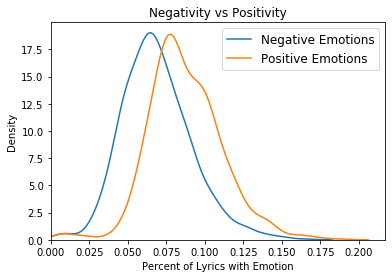

In [5]:
sns.distplot(df['negative'], hist=False, label='Negative Emotions')
sns.distplot(df['positive'], hist=False, label='Positive Emotions')
plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Negativity vs Positivity')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density')  
plt.savefig('pics/pos-neg.png')

In [10]:
pos_mean = df['positive'].mean().round(3)
neg_mean = df['negative'].mean().round(3)

print('The positive emotions mean is ' + str(pos_mean) + 
      '. The negative emotions mean is ' + str(neg_mean))

The positive emotions mean is 0.087. The negative emotions mean is 0.069


I would like to know if the mean value for positivity is the same as the mean value for negativity. We use a two sample t-test. 

In [12]:
t, p = stat.ttest_rel(df['positive'], df['negative'])
p

8.402319960026112e-62

The difference in the means of the positive and negative emotions is significant. 

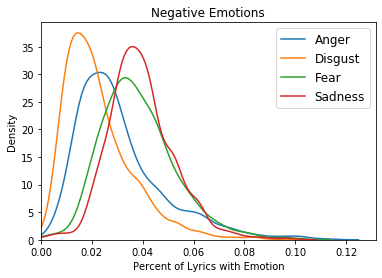

In [11]:
sns.distplot(df['anger'],   hist=False, label='Anger')
sns.distplot(df['disgust'], hist=False, label='Disgust')
sns.distplot(df['fear'],    hist=False, label='Fear')
sns.distplot(df['sadness'], hist=False, label='Sadness')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Negative Emotions')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density')
plt.savefig('pics/negs.png')

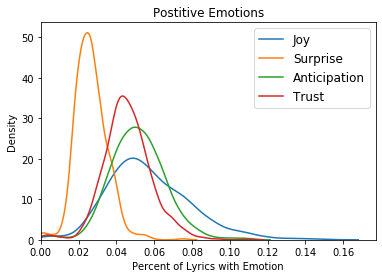

In [12]:
sns.distplot(df['joy'], hist=False, label='Joy')
sns.distplot(df['surprise'], hist=False, label='Surprise')
sns.distplot(df['anticipation'], hist=False, label='Anticipation')
sns.distplot(df['trust'], hist=False, label='Trust')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Postitive Emotions')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density')  
plt.savefig('pics/pozs.png')

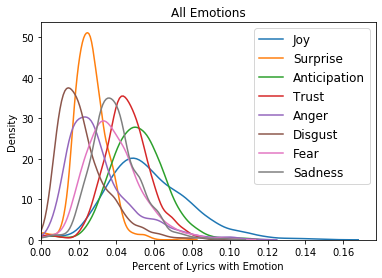

In [13]:
sns.distplot(df['joy'],          hist=False, label='Joy')
sns.distplot(df['surprise'],     hist=False, label='Surprise')
sns.distplot(df['anticipation'], hist=False, label='Anticipation')
sns.distplot(df['trust'],        hist=False, label='Trust')
sns.distplot(df['anger'],        hist=False, label='Anger')
sns.distplot(df['disgust'],      hist=False, label='Disgust')
sns.distplot(df['fear'],         hist=False, label='Fear')
sns.distplot(df['sadness'],      hist=False, label='Sadness')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('All Emotions')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density')  
plt.savefig('pics/all-emotions.png')
# statistically significant?  

We would like to investigate whether the differences in the mean values for each of the emotions are significantly different. First we perform an ANOVA test to determine if any of the means are significantly different. Then, because the ANOVA test affirms that at least one pair is significantly different, we use the Pairwise Tukey HSD test to test all emotion pairs, which automatically adjusts our conficence bounds to control the type I error rate. 

In [15]:
# ANOVA test
f, p = stat.f_oneway(df['joy'], 
                     df['surprise'],
                     df['anticipation'],
                     df['trust'],
                     df['anger'],
                     df['disgust'],
                     df['fear'],
                     df['sadness'])
p

0.0

To perform a pairwise comparison test, we need to reshape our data.

In [17]:
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df.reset_index(), id_vars=['Artist'], 
                   value_vars = ['joy', 'surprise','anticipation', 'trust',
                                 'anger','disgust','fear','sadness'])

# replace column names
df_melt.columns = ['Artist', 'Emotion', 'value']
df_melt

,Artist,Emotion,value
0,O.T. Genasis,joy,0.050603
1,Dean Lewis,joy,0.053738
2,Edwin Starr,joy,0.080381
3,Cali Swag District,joy,0.052390
4,The Marshall Tucker Band,joy,0.061006
...,...,...,...
9891,Sylvia Plath,sadness,0.063012
9892,Irving Berlin,sadness,0.041284
9893,Calvin Harris,sadness,0.022772
9894,Ace Frehley,sadness,0.041254


Now we can perform a pairwise comparison test on each of the emotions.

In [18]:
multi_comp = pairwise_tukeyhsd(endog=df_melt['value'], groups=df_melt['Emotion'], 
                               alpha=0.05)
print(multi_comp)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
       anger anticipation     0.02  0.001  0.0182  0.0219   True
       anger      disgust  -0.0086  0.001 -0.0105 -0.0068   True
       anger         fear   0.0071  0.001  0.0053   0.009   True
       anger          joy    0.026  0.001  0.0242  0.0278   True
       anger      sadness   0.0082  0.001  0.0064  0.0101   True
       anger     surprise  -0.0046  0.001 -0.0064 -0.0027   True
       anger        trust   0.0146  0.001  0.0128  0.0165   True
anticipation      disgust  -0.0286  0.001 -0.0305 -0.0268   True
anticipation         fear  -0.0129  0.001 -0.0147 -0.0111   True
anticipation          joy    0.006  0.001  0.0041  0.0078   True
anticipation      sadness  -0.0118  0.001 -0.0136 -0.0099   True
anticipation     surprise  -0.0246  0.001 -0.0264 -0.0228   True
anticipation        trust

All pairwise comparisons are statistically significant except for fear-sadness. However, the practical significance of some of the comparisons is up for debate. For example, the mean of disgust is 0.4% larger than the mean of surprise. Would the average music listener really notice a difference? Let's unpack that question. 

Interestingly, the while the means of disgust and surprise are very close, the shapes of the distributions are somewhat different. This is something that the statistical test will not pick up, but I think is worth noting. 

Text(0, 0.5, 'Density')

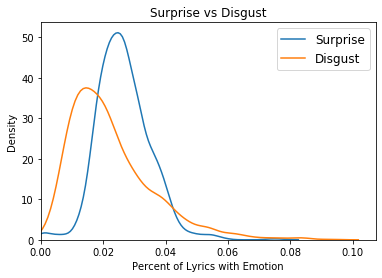

In [75]:
sns.distplot(df1['surprise'], hist=False, label='Surprise')
sns.distplot(df1['disgust'], hist=False, label='Disgust')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Surprise vs Disgust')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density') 

The peaks of the two distributions are in different places, but their means (that is, their center of mass) are almost equal. 

The distribution of surprise is tall and symmetrical. We see that almost everybody displays surprise in their lyrics between 1.5% and 4% of the time. This matches with my intuition on the nature of surprise. Nobody can be surprised very often (otherwise it wouldn't be much of a surprise), but most everybody is surprised sometimes (otherwise they would have to always be right or else not think at all about the future). 

Disgust, on the other hand, has a wider distribution with a right skew. Some artists almost never display disgust. Others are disgusted quite often. Six artists emote disgust with more than 8% of their lyrics. Twenty-two artists emote disgust with less than 0.5% of their lyrics (to be fair, for a few of those artists that ratio may be artificially low because many of their lyrics are in different languages). This makes sense to me. Some people are very rarely dsgusted. They seem to accept most things as they are. Others are disgusted quite often and demand some change to be made. 

The fact that the algorithm picked up these differences in distributions that match with my intuition about how human emotions work gives me confidence that the algorithm is picking up real patterns and intentions in the lyrics. 

As to the original question of whether people would notice a practical difference in the amount of disgust and surprise in their music, my suspicion is yes. I would think that many people would gravitate to music with higher or lower levels of disgust to match their personal preferences. Surprise, on the other hand, seems more universal and harder to pick and choose. So it seems likely to me that some people are exposed to more disgust than surprise in their music, while others are exposed to more surprise than disgust. Unfortunately, we do not have the data to make a data-informed conculsion about this question. 

Text(0, 0.5, 'Density')

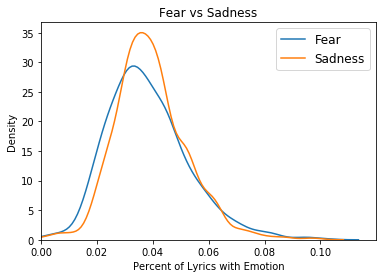

In [20]:
sns.distplot(df['fear'], hist=False, label='Fear')
sns.distplot(df['sadness'], hist=False, label='Sadness')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Fear vs Sadness')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density') 

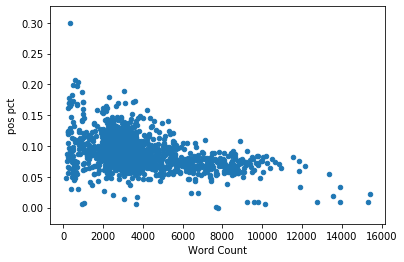

In [101]:
df1.plot(kind='scatter', x='Word Count', y='pos pct')

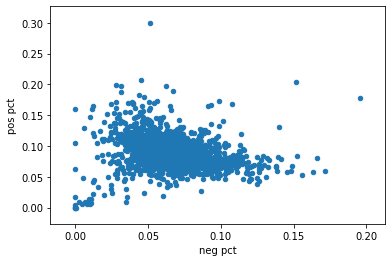

In [75]:
df1.plot(kind='scatter', x='neg pct', y='pos pct')

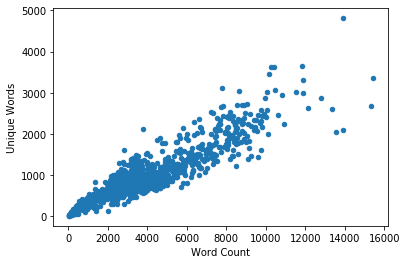

In [77]:
df1.plot(kind='scatter', x='Word Count', y='Unique Words')

In [ ]:
add genre to df based on artist? 

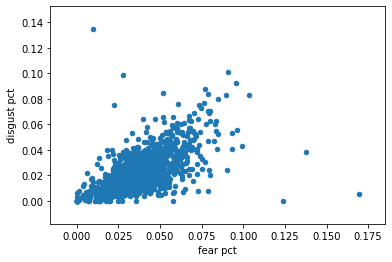

In [78]:
df1.plot(kind='scatter', x='fear pct', y='disgust pct')

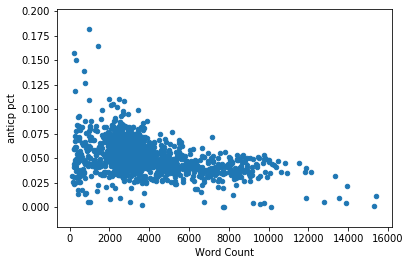

In [111]:
df1.plot(kind='scatter', x='Word Count', y='anticp pct')

In [51]:
df1.sort_values('Word Count', ascending=False).head(10)

NameError: name 'df1' is not defined

In [137]:
df1.sort_values('Unique Words', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
889,Taco Hemingway,teraz porozmawiajmy pieniądzach zauważyliście ...,13903,4810,0.009135,0.002733,0.003596,0.003740,0.000719,0.001510,0.007840,0.001151,0.007337,0.003668
308,Eminem,look gonna go easy hurt feelings going get one...,11835,3648,0.058893,0.094043,0.053908,0.036079,0.041572,0.051120,0.025602,0.046726,0.022983,0.033545
1090,Bad Meets Evil,uh first verse uh armed til island life ridin ...,10396,3638,0.063775,0.110716,0.062235,0.040881,0.047903,0.059446,0.028088,0.049154,0.027126,0.036553
610,Lupe Fiasco,yeah say bitch bad woman good lady better hey ...,10262,3616,0.073085,0.098421,0.051647,0.042487,0.035958,0.059637,0.037517,0.047749,0.025434,0.052329
760,GQ,turned 19 spent birthday watching bruce almigh...,10181,3463,0.083391,0.084569,0.045870,0.044396,0.033985,0.039191,0.037914,0.037521,0.028583,0.049013
1030,Psy 4 de la Rime,juste le temps un instant voir la vie autremen...,15423,3350,0.022045,0.011930,0.008948,0.010958,0.003047,0.005706,0.009985,0.005382,0.006095,0.011217
523,Lil Dicky,world boy one guys well could specific uh huma...,11862,3319,0.075704,0.092986,0.058338,0.039454,0.046198,0.041983,0.035576,0.031276,0.020401,0.045776
134,​the Chemodan Clan,на зубах не фиксы фиксы на минус ложатся выхва...,7766,3117,0.000000,0.000644,0.000386,0.000386,0.000258,0.000386,0.000000,0.000129,0.000000,0.000515
1079,Chamillionaire,see rollin hatin patrollin tryna catch ridin d...,10473,3074,0.078965,0.081448,0.045546,0.047264,0.028550,0.043350,0.039912,0.037716,0.035329,0.051084


In [149]:
df1.sort_values('pos pct', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
949,Jody Watley,ever stabbed back someone thought really cool ...,3591,709,0.173211,0.056252,0.013924,0.043163,0.009747,0.034809,0.142579,0.039543,0.017822,0.049011
959,Bill Withers,sunshine gone warm away sunshine gone always g...,2213,713,0.162223,0.051062,0.018527,0.065070,0.013104,0.032535,0.130592,0.034794,0.040669,0.070944
1055,Babyface,girl long long time comin yes know worth wait ...,4190,789,0.157995,0.050597,0.021480,0.060143,0.010740,0.024821,0.103580,0.026969,0.032697,0.068019
327,The Whispers,beat goes like love everlasting beat goes stil...,3463,729,0.152180,0.044759,0.014438,0.062085,0.008374,0.031476,0.116373,0.032919,0.036962,0.056310
1353,The Bellamy Brothers,reason sun shining sky reason feeling high mus...,2931,959,0.147049,0.046401,0.016718,0.074719,0.011941,0.037530,0.101331,0.035824,0.042989,0.067213
25,Roberta Flack,first time ever saw face thought sun rose eyes...,2682,743,0.146905,0.060030,0.013796,0.098434,0.014169,0.031320,0.115585,0.041014,0.040641,0.077554
1032,The Spinners,hand walkin cane hand hat hurry late cause got...,4368,865,0.145375,0.055174,0.016712,0.046703,0.033654,0.026557,0.110119,0.033196,0.023581,0.050595
581,Sheila E.,wears long fur coat mink even summer time ever...,4006,955,0.145032,0.057913,0.018972,0.057913,0.024214,0.032202,0.080629,0.041687,0.021967,0.051173
840,Klymaxx,love share place special good times together s...,3429,744,0.143774,0.057160,0.016040,0.099446,0.014582,0.028580,0.120152,0.025080,0.076699,0.085156


In [150]:
df1.sort_values('neg pct', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
1144,21 Savage & Metro Boomin,ten bad bitches mansion wrist milly rock diamo...,3622,908,0.052733,0.155439,0.113749,0.024296,0.083103,0.103258,0.024296,0.095527,0.025953,0.031750
1445,Blac Youngsta,beatmonster yung lan track twerk twerk twerk g...,8288,1472,0.083374,0.152268,0.095198,0.029199,0.055623,0.096284,0.035956,0.059604,0.030888,0.046935
652,Megan Thee Stallion,real hot girl shit yeah bag every time see got...,8618,1503,0.066721,0.148758,0.100487,0.030750,0.083894,0.079021,0.030285,0.063704,0.023091,0.038988
409,Ramirez,playa hataz playa hataz playa hataz playa hata...,5680,1644,0.059331,0.148415,0.080106,0.025704,0.054225,0.073768,0.020599,0.069718,0.039085,0.029401
991,Sheck Wes,16yrold bitch daytrip took 10 got hoes callin ...,7226,1453,0.058400,0.145309,0.103653,0.040133,0.092721,0.095489,0.035704,0.081096,0.030030,0.028923
904,21 Savage,ooh ooh ooh ow ow ow wow wow ow ah ow ah ah ah...,9532,2063,0.078997,0.141209,0.085921,0.050567,0.053399,0.092950,0.050042,0.063890,0.040705,0.063366
17,Quiet Riot,cum feel noize girls rock boys get wild wild w...,3127,720,0.082827,0.139431,0.059162,0.038695,0.063959,0.072594,0.050208,0.075791,0.056924,0.032939
900,BlocBoy JB,tay keith fuck niggas yeah yeah ooh yeah ooh 6...,7674,1694,0.058900,0.138389,0.104900,0.026323,0.062940,0.079880,0.016549,0.046521,0.015116,0.043263
190,Calboy,lay sleep lay sleep ayy pray lord soul keep pr...,6961,1521,0.068094,0.137624,0.071541,0.031030,0.060336,0.083178,0.038644,0.072403,0.029019,0.039793


In [151]:
df1.sort_values('anger pct', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
1144,21 Savage & Metro Boomin,ten bad bitches mansion wrist milly rock diamo...,3622,908,0.052733,0.155439,0.113749,0.024296,0.083103,0.103258,0.024296,0.095527,0.025953,0.031750
757,Lil Reese,really talking bitch bout action bout life man...,5313,1191,0.066441,0.137587,0.110296,0.036702,0.076416,0.076416,0.031997,0.062488,0.031621,0.053077
900,BlocBoy JB,tay keith fuck niggas yeah yeah ooh yeah ooh 6...,7674,1694,0.058900,0.138389,0.104900,0.026323,0.062940,0.079880,0.016549,0.046521,0.015116,0.043263
991,Sheck Wes,16yrold bitch daytrip took 10 got hoes callin ...,7226,1453,0.058400,0.145309,0.103653,0.040133,0.092721,0.095489,0.035704,0.081096,0.030030,0.028923
1036,Famous Dex,hey yo big bro fucking ha okay cool good job 1...,6640,1232,0.077560,0.132982,0.100753,0.051807,0.083434,0.089608,0.036145,0.080120,0.034187,0.046687
652,Megan Thee Stallion,real hot girl shit yeah bag every time see got...,8618,1503,0.066721,0.148758,0.100487,0.030750,0.083894,0.079021,0.030285,0.063704,0.023091,0.038988
1437,Bobby Shmurda,tryna make next motherfuckin scene huh fucking...,4873,1212,0.043710,0.126411,0.100144,0.027498,0.054997,0.083316,0.019495,0.063000,0.025036,0.035091
593,Trinidad James,shit sound like 007 n64 shit yeah yeah yeah ye...,6562,1675,0.084273,0.128772,0.099970,0.048004,0.080311,0.084730,0.037031,0.060957,0.028193,0.046480
427,Cardi B,ksr cardi ayy said shit fuck wanted dont gotta...,8028,1856,0.074365,0.118460,0.096537,0.050947,0.062407,0.068510,0.047085,0.059915,0.040110,0.053064


In [152]:
df1.sort_values('anticp pct', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
546,Bruce Willis,dance every dance guy gives eye let hold tight...,2102,765,0.120837,0.081827,0.029496,0.104186,0.021884,0.039010,0.092769,0.034729,0.045195,0.059943
840,Klymaxx,love share place special good times together s...,3429,744,0.143774,0.057160,0.016040,0.099446,0.014582,0.028580,0.120152,0.025080,0.076699,0.085156
25,Roberta Flack,first time ever saw face thought sun rose eyes...,2682,743,0.146905,0.060030,0.013796,0.098434,0.014169,0.031320,0.115585,0.041014,0.040641,0.077554
624,Cyndi Lauper,lying bed hear clock tick think caught circles...,2688,736,0.110491,0.094122,0.025670,0.095238,0.013393,0.053943,0.076265,0.060268,0.037574,0.060268
1291,"Crosby, Stills & Nash",helplessly hoping harlequin hovers nearby awai...,2265,896,0.082561,0.050773,0.024724,0.090949,0.015894,0.033554,0.053863,0.047682,0.026932,0.049448
138,Perry Como,heard sang good song heard style came see list...,2223,712,0.143050,0.049033,0.007647,0.088169,0.008997,0.033288,0.112011,0.042285,0.035987,0.079172
987,Soul II Soul,back life back reality back life back reality ...,3703,720,0.084256,0.025655,0.010532,0.085876,0.006481,0.037267,0.051580,0.018634,0.013503,0.046989
83,Peter Wolf,baby please let go cause love girl want know s...,2657,746,0.066616,0.065487,0.019947,0.084682,0.009785,0.028604,0.047422,0.037260,0.027851,0.029356
699,John Denver,almost heaven west virginia blue ridge mountai...,2706,846,0.107539,0.044346,0.014412,0.083888,0.016999,0.026977,0.076127,0.034738,0.031042,0.063562


In [81]:
df1.sort_values('disgust', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
index,,,,,,,,,,,,,,
991,Sheck Wes,16yrold bitch daytrip took 10 got hoes callin ...,7226,1453,0.058400,0.145309,0.103653,0.040133,0.092721,0.095489,0.035704,0.081096,0.030030,0.028923
838,Miami Sound Machine,come shake body baby conga know control longer...,3788,844,0.071014,0.099525,0.057814,0.025343,0.084741,0.051742,0.032207,0.051742,0.014520,0.025871
652,Megan Thee Stallion,real hot girl shit yeah bag every time see got...,8618,1503,0.066721,0.148758,0.100487,0.030750,0.083894,0.079021,0.030285,0.063704,0.023091,0.038988
1036,Famous Dex,hey yo big bro fucking ha okay cool good job 1...,6640,1232,0.077560,0.132982,0.100753,0.051807,0.083434,0.089608,0.036145,0.080120,0.034187,0.046687
1144,21 Savage & Metro Boomin,ten bad bitches mansion wrist milly rock diamo...,3622,908,0.052733,0.155439,0.113749,0.024296,0.083103,0.103258,0.024296,0.095527,0.025953,0.031750
593,Trinidad James,shit sound like 007 n64 shit yeah yeah yeah ye...,6562,1675,0.084273,0.128772,0.099970,0.048004,0.080311,0.084730,0.037031,0.060957,0.028193,0.046480
757,Lil Reese,really talking bitch bout action bout life man...,5313,1191,0.066441,0.137587,0.110296,0.036702,0.076416,0.076416,0.031997,0.062488,0.031621,0.053077
1317,Young Dro,westside bankhead everything done true game sh...,8360,1936,0.063636,0.127512,0.094617,0.022967,0.075359,0.073325,0.025598,0.071172,0.019976,0.040311
710,Simon & Garfunkel,hello darkness old friend come talk vision sof...,2380,998,0.082353,0.113866,0.081513,0.042437,0.075210,0.022269,0.047479,0.096639,0.017227,0.047899


In [154]:
df1.sort_values('fear pct', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
1144,21 Savage & Metro Boomin,ten bad bitches mansion wrist milly rock diamo...,3622,908,0.052733,0.155439,0.113749,0.024296,0.083103,0.103258,0.024296,0.095527,0.025953,0.031750
1445,Blac Youngsta,beatmonster yung lan track twerk twerk twerk g...,8288,1472,0.083374,0.152268,0.095198,0.029199,0.055623,0.096284,0.035956,0.059604,0.030888,0.046935
991,Sheck Wes,16yrold bitch daytrip took 10 got hoes callin ...,7226,1453,0.058400,0.145309,0.103653,0.040133,0.092721,0.095489,0.035704,0.081096,0.030030,0.028923
904,21 Savage,ooh ooh ooh ow ow ow wow wow ow ah ow ah ah ah...,9532,2063,0.078997,0.141209,0.085921,0.050567,0.053399,0.092950,0.050042,0.063890,0.040705,0.063366
1036,Famous Dex,hey yo big bro fucking ha okay cool good job 1...,6640,1232,0.077560,0.132982,0.100753,0.051807,0.083434,0.089608,0.036145,0.080120,0.034187,0.046687
703,XXXTENTACION,yeah someone afraid let go uh decide ever gonn...,4082,1093,0.054140,0.119059,0.061489,0.028662,0.052180,0.085007,0.032827,0.080108,0.017883,0.032092
593,Trinidad James,shit sound like 007 n64 shit yeah yeah yeah ye...,6562,1675,0.084273,0.128772,0.099970,0.048004,0.080311,0.084730,0.037031,0.060957,0.028193,0.046480
1205,YNW Melly,get roll ayy studio bro oh nah yeah call ball ...,7204,1527,0.070378,0.126458,0.080927,0.036785,0.062743,0.083426,0.037896,0.069406,0.035675,0.034148
1437,Bobby Shmurda,tryna make next motherfuckin scene huh fucking...,4873,1212,0.043710,0.126411,0.100144,0.027498,0.054997,0.083316,0.019495,0.063000,0.025036,0.035091


In [155]:
df1.sort_values('joy pct', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
949,Jody Watley,ever stabbed back someone thought really cool ...,3591,709,0.173211,0.056252,0.013924,0.043163,0.009747,0.034809,0.142579,0.039543,0.017822,0.049011
959,Bill Withers,sunshine gone warm away sunshine gone always g...,2213,713,0.162223,0.051062,0.018527,0.065070,0.013104,0.032535,0.130592,0.034794,0.040669,0.070944
1361,Karyn White,early morning put breakfast table make sure co...,4985,758,0.138014,0.051755,0.013240,0.046740,0.015246,0.023270,0.123571,0.024674,0.016851,0.041525
591,Sister Sledge,family got sisters family get everybody sing f...,3047,731,0.139481,0.045619,0.011487,0.053167,0.011487,0.019691,0.121103,0.037414,0.019035,0.040696
840,Klymaxx,love share place special good times together s...,3429,744,0.143774,0.057160,0.016040,0.099446,0.014582,0.028580,0.120152,0.025080,0.076699,0.085156
566,Club Nouveau,sometimes lives pain sorrow wise know always t...,4566,734,0.141261,0.101183,0.059571,0.074901,0.045116,0.057381,0.118922,0.063732,0.038546,0.085633
327,The Whispers,beat goes like love everlasting beat goes stil...,3463,729,0.152180,0.044759,0.014438,0.062085,0.008374,0.031476,0.116373,0.032919,0.036962,0.056310
25,Roberta Flack,first time ever saw face thought sun rose eyes...,2682,743,0.146905,0.060030,0.013796,0.098434,0.014169,0.031320,0.115585,0.041014,0.040641,0.077554
138,Perry Como,heard sang good song heard style came see list...,2223,712,0.143050,0.049033,0.007647,0.088169,0.008997,0.033288,0.112011,0.042285,0.035987,0.079172


In [156]:
df1.sort_values('sadness pct', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
710,Simon & Garfunkel,hello darkness old friend come talk vision sof...,2380,998,0.082353,0.113866,0.081513,0.042437,0.075210,0.022269,0.047479,0.096639,0.017227,0.047899
1144,21 Savage & Metro Boomin,ten bad bitches mansion wrist milly rock diamo...,3622,908,0.052733,0.155439,0.113749,0.024296,0.083103,0.103258,0.024296,0.095527,0.025953,0.031750
632,Lita Ford,baby get scared inside really understand love ...,2663,821,0.085618,0.108149,0.047315,0.050695,0.028915,0.072475,0.059707,0.087871,0.037552,0.030792
91,Nazareth,love hurts love scars love wounds marks heart ...,2187,779,0.076818,0.107910,0.062186,0.042981,0.052583,0.070873,0.053955,0.086877,0.026520,0.036123
329,Pretenders,got brass pocket got bottle gonna use intentio...,2495,907,0.089780,0.113026,0.056914,0.063327,0.040481,0.058918,0.065331,0.083768,0.029659,0.036072
991,Sheck Wes,16yrold bitch daytrip took 10 got hoes callin ...,7226,1453,0.058400,0.145309,0.103653,0.040133,0.092721,0.095489,0.035704,0.081096,0.030030,0.028923
1036,Famous Dex,hey yo big bro fucking ha okay cool good job 1...,6640,1232,0.077560,0.132982,0.100753,0.051807,0.083434,0.089608,0.036145,0.080120,0.034187,0.046687
703,XXXTENTACION,yeah someone afraid let go uh decide ever gonn...,4082,1093,0.054140,0.119059,0.061489,0.028662,0.052180,0.085007,0.032827,0.080108,0.017883,0.032092
1415,Willie Nelson,cruel cruel world must go cruel cruel world mo...,2250,711,0.101333,0.088889,0.044000,0.064000,0.023556,0.060444,0.067111,0.077778,0.035556,0.058667


In [157]:
df1.sort_values('surprise pct', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
840,Klymaxx,love share place special good times together s...,3429,744,0.143774,0.057160,0.016040,0.099446,0.014582,0.028580,0.120152,0.025080,0.076699,0.085156
125,Mötley Crüe,know dreamer heart gold run away high come hom...,3256,869,0.101658,0.102580,0.061118,0.070332,0.038084,0.055590,0.064189,0.060811,0.073403,0.058968
1109,Troye Sivan,run away left today said goodbye safe sound ha...,3672,825,0.119826,0.113834,0.027233,0.078704,0.032680,0.050654,0.085240,0.060458,0.059368,0.055828
17,Quiet Riot,cum feel noize girls rock boys get wild wild w...,3127,720,0.082827,0.139431,0.059162,0.038695,0.063959,0.072594,0.050208,0.075791,0.056924,0.032939
1433,Andrew Gold,creepy kooky mysterious spooky together ooky a...,2478,852,0.100081,0.096852,0.044391,0.055690,0.043180,0.065375,0.077482,0.036320,0.054883,0.056094
866,Thompson Square,sitting momma roof talking bout everything moo...,3223,744,0.095253,0.067329,0.034750,0.067329,0.015513,0.039404,0.073224,0.034440,0.054297,0.048402
855,Three 6 Mafia,triple six ol pussy ass cake ass punk ass tric...,9911,2492,0.047624,0.124912,0.061750,0.030875,0.051962,0.063667,0.021289,0.046413,0.053476,0.034507
1167,Jessie J,tomorrow comes feeling frightened things know ...,4815,1054,0.121911,0.079335,0.036968,0.069367,0.021807,0.037175,0.075389,0.040498,0.050675,0.075597
1322,Hozier,lover got humor giggle funeral knows everybody...,3600,1126,0.135000,0.093056,0.040000,0.081944,0.035833,0.060833,0.097222,0.053611,0.049722,0.074444


In [158]:
df1.sort_values('trust pct', ascending=False).head(10)

,Artist,Lyrics,Word Count,Unique Words,pos pct,neg pct,anger pct,anticp pct,disgust pct,fear pct,joy pct,sadness pct,surprise pct,trust pct
index,,,,,,,,,,,,,,
566,Club Nouveau,sometimes lives pain sorrow wise know always t...,4566,734,0.141261,0.101183,0.059571,0.074901,0.045116,0.057381,0.118922,0.063732,0.038546,0.085633
840,Klymaxx,love share place special good times together s...,3429,744,0.143774,0.057160,0.016040,0.099446,0.014582,0.028580,0.120152,0.025080,0.076699,0.085156
535,George Michael,let give gotta faith sound one good thing got ...,3729,860,0.133816,0.050416,0.020649,0.081255,0.018772,0.030035,0.111826,0.026549,0.028426,0.081523
1410,Marvin Gaye,mother mother many crying brother brother brot...,3148,795,0.137865,0.049238,0.020013,0.066074,0.018107,0.031131,0.103240,0.033037,0.031449,0.080051
138,Perry Como,heard sang good song heard style came see list...,2223,712,0.143050,0.049033,0.007647,0.088169,0.008997,0.033288,0.112011,0.042285,0.035987,0.079172
777,Manfred Mann’s Earth Band,blinded light revved like deuce another runner...,3066,912,0.097847,0.076321,0.028702,0.062948,0.012394,0.039791,0.062948,0.037834,0.039465,0.077626
25,Roberta Flack,first time ever saw face thought sun rose eyes...,2682,743,0.146905,0.060030,0.013796,0.098434,0.014169,0.031320,0.115585,0.041014,0.040641,0.077554
637,Tina Turner,must understand though touch hand makes pulse ...,3247,830,0.131198,0.074222,0.035109,0.071759,0.023714,0.047736,0.095473,0.047120,0.042809,0.076994
839,The Undisputed Truth,smiling faces sometimes pretend friend smiling...,4059,861,0.117517,0.060360,0.018970,0.043607,0.017738,0.033506,0.082533,0.051737,0.031042,0.076127
